In [ ]:
# !pip install googletrans==3.1.0a0
# !pip install konlpy
# !pip install pyLDAvis

In [ ]:
import pandas as pd
import re
import konlpy
import wordcloud
import os
import gensim
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from konlpy.tag import Komoran
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator
trans = Translator()
komoran = Komoran(userdic = "/content/drive/MyDrive/graduation/komoran_dict.txt") #기본사전 + 사용자사전

stopwords_path = "/content/drive/MyDrive/graduation/stopwords.txt"

with open(stopwords_path, encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [w.strip() for w in stopwords]

In [ ]:
#전처리 함수 만들기(이상치를 제거한 데이터에서 수행)
def preprocessing(text):
    #외국어 번역 - 문장이 외국어(영어, 일본어, 중국어, 아랍어)로만 또는 외국어와 숫자의 조합으로 작성된 경우에만 한국어로 번역
    text=re.sub(r'[^A-Za-z가-힇ㄱ-ㅎㅏ-ㅣ\s0-9ぁ-ゔァ-ヴー々〆〤一-龥\u0600-\u06FF]', '',text) #공백, 숫자, 문자만 남아있음
    if not bool(re.search(r'[ㅏ-ㅣㄱ-ㅎ가-힇]', text)): #한글이 전혀 들어가 있지 않은 문장인 경우
      if all([w.isalnum() for w in text.split()]): #문장이 외국어로만 또는 외국어와 숫자의 조합으로만 구성되어 있을 때만 번역기 적용
        text = translate(text)
        
    #정규화
    text = normalization(text)
    
    #형태소 분석 및 불용어 제거
    bag = cleaning(text)
    
    #단어로 구성된 리스트를 반환
    return bag

In [ ]:
#2. 외국어-한국어 번역 함수
def translate(text:str): #번역할 문장(문자열) 입력
    
    result = trans.translate(text, dest = 'ko')
    text = result.text
    return text

In [ ]:
#3. 정규화 함수

def normalization(text):
    ##영어 단어의 소문자화
    text = text.lower()
    
    ##동의어 통일
    #갤럭시 시리즈
    text = re.sub(r'(갤럭시|galaxy)\s*(z|지)*\s*(플립|flip)\s*(일|1)*','플립',text)
    text = re.sub(r'(갤럭시|galaxy)\s*(z|지)*\s*(폴드|fold)\s*(일|1)*','폴드',text)
    text = re.sub(r'(갤럭시|galaxy)\s*(z|지)*\s*(플립|flip)\s*(삼|3)','플립',text)
    text = re.sub(r'(갤럭시|galaxy)\s*(z|지)*\s*(폴드|fold)\s*(삼|3)','폴드',text)
    text = re.sub(r'(갤럭시|galaxy)\s*(z|지)*\s*(폴드|fold)\s*(사|4)*','폴드',text)
    text = re.sub(r'(갤럭시|galaxy)\s*(z|지)*\s*(플립|flip)\s*(사|4)*','플립',text)
    text = re.sub(r'(갤럭시|galaxy)\s*(s|에스)\s*(이십이|22)','갤럭시에스이십이',text)
    text = re.sub(r'(갤럭시|galaxy)\s*(s|에스)\s*(이십일|21)','갤럭시에스이십일',text)
    text = re.sub(r'(갤럭시|galaxy)\s*(s|에스)\s*(이십|20)','갤럭시에스이십',text)
    text = re.sub(r'(갤럭시|galaxy)\s*(note|노트)\s*(이십|트웬티|20)','갤럭시노트이십',text)
    text = re.sub(r'(갤럭시|galaxy)\s*(note|노트)\s*(10|십|텐)','갤럭시노트십',text)
    
    #애플 시리즈
    text = re.sub(r'(아이폰|iphone)\s*(13|십삼|서틴)','아이폰십삼',text)
    text = re.sub(r'(아이폰|iphone)\s*(13|십삼|서틴)\s*(프로|pro)','아이폰십삼프로',text)
    text = re.sub(r'(아이폰|iphone)\s*(13|십삼|서틴)\s*(프로|pro)\s*(맥스|max)','아이폰십삼프로맥스',text)
    text = re.sub(r'(아이폰|iphone)\s*(12|십이|트웰브)','아이폰십이',text)
    text = re.sub(r'(아이폰|iphone)\s*(12|십이|트웰브)\s*(프로|pro)','아이폰십이프로',text)
    text = re.sub(r'(아이폰|iphone)\s*(12|십이|트웰브)\s*(프로|pro)\s*(맥스|max)','아이폰십이프로맥스',text)

    #나머지 단어들 동의어 통일
    text = re.sub(r'대한민국|한국|korea','한국',text)
    text = re.sub(r'미국|아메리카|us|usa|u.s.a','미국',text)
    text = re.sub(r's(\s*펜|\s*pen)','에스펜',text)
    
    #오타정정 및 그 외 작업
    text = re.sub('(배테리|밧데리|배터리)','배터리',text)
    
    text = re.sub(r'멀티\s*(태|테)스킹','멀티태스킹',text)
    text = re.sub('(잇|이)쁘','예쁘',text)
    text = text.replace('색', '색깔')
    text = text.replace('색깔깔', '색깔')
    text = text.replace('하면', '화면')
    text = text.replace('(폴더|더블)', '폴더블')
    
    #복합명사 복원
    text = re.sub(r'커버\s*디스플레이', '커버디스플레이',text)
    text = re.sub(r'언더\s*디스플레이\s*카메라','언더디스플레이카메라',text)
    
    ##한국어 발음의 알파벳 표기를 한글로 표현
    text = re.sub('samsung', '삼성', text)
    text = re.sub('gamsung', '감성', text)
    text = re.sub('iphone', '아이폰', text)
    text = re.sub('galaxy', '갤럭시', text)
    
    #줄임말 복원
    text = text.replace('삼페', '삼성페이').replace('애페', '애플페이').replace('기변욕구','기기 변경 욕구')
    
    #전문용어(영어 약자) 한국어 번역
    text = text.replace('gif', '움짤').replace('udc', '언더디스플레이카메라').replace('gos','게임옵티마이징서비스').replace('oled','유기발광다이오드').replace('hz','주사율').replace('mah','미리암페어')
    
    #텍스트 반환
    return text

In [ ]:
#4. 형태소 분석 및 불용어 제거
def cleaning(text):
    text = re.sub(r'[^가-힇]','',text) #한글만 남김
    postagged = komoran.pos(text) #형태소단위로 문장 분절

    #일반명사, 고유명사, 형용사, 동사를 제외한 모든 품사 단어들은 제거
    words = []
    for w, p in postagged:
      if p in ['NNG','NNP','VA', 'VV']:
        if p in ['VA','VV']:
          ws = w+'다' #어미복원 - 용언 어간에 어미 '-다' 삽입
          words.append(ws)
        else:  
          words.append(w)

    re_words = [w for w in words if w not in stopwords] #불용어 제거
    last_text=' '.join(re_words)
    last_text = normalization(last_text) #형태소분석 후 2차 정규화
    
    re_words = last_text.split()
    re_words = [w for w in re_words if len(w)>1] #1음절 단어는 의미를 잘 이해할 수 없으므로 제거
    return re_words

In [ ]:
#zflip 파일 처리

In [ ]:
zflip3_comment_words = pd.DataFrame(columns = ['comment_list'])

In [ ]:
new_df = pd.read_csv('/content/drive/MyDrive/graduation/new_df_flip.csv', lineterminator='\n')

In [ ]:
zflip3_comment_words['comment_list'] = new_df['REPLY'].apply(lambda x: preprocessing(x))

In [ ]:
zflip3_comment_words.to_csv('/content/drive/MyDrive/graduation/flip_word_bags.csv', index=False)

In [ ]:
zflip3_comment_words

,comment_list
0,"[느끼다, 기업, 장단점, 좋다, 건너뛰다, 재밌다]"
1,"[가정, 순간, 센스, 넘치다]"
2,"[플립, 좋다, 개선, 정리, 시청, 배터리, 녹다, 그리다, 지문인식, 빠르다, ..."
3,"[플립, 넘어오다, 데일, 만족, 배터리, 가조, 아쉽다, 디자인, 계속, 질리다,..."
4,"[배터리, 크다, 단점, 이기다, 저번, 분해, 보니, 위쪽, 공간, 털다, 배터리..."
...,...
9893,"[순간, 개그, 박성호]"
9894,"[예쁘다, 좋다, 여성]"
9895,"[어울리다, 계속, 슬다]"
9896,"[화면, 벌다, 법도, 가지가지, 고도]"


In [ ]:
#zfold 파일 처리

In [ ]:
new_df['REPLY'] = new_df['REPLY'].apply(lambda x: str(x))

In [ ]:
new_df = pd.read_csv('/content/drive/MyDrive/graduation/new_df_fold.csv', lineterminator='\n')

In [ ]:
new_df

,REPLY,length,log_length
0,왜 모든걸 다할수있게 만들어놓고 외장메모리를 못쓰게해놨을까요ㅜㅠ10년간 갤럭시 주구...,418,6.037871
1,이번 폴드와 플립 완성도가 상당히 높다 생각됩니다.시장에 영향이 있을정도로 많이 팔...,61,4.127134
2,1년 뒤에 폴드4가 나오면 그땐 정말 완성형이 되지 않을까요? 이번에 폴드2 쓰다가...,104,4.653960
3,"판매량이 폴더시리즈 역대급 이네요. 없어서 못 팔 지경이라니, 앞으로 새로운 생태계...",52,3.970292
4,역시 장단점을 고르게 언급해주셨네요.믿고 보는 잇섭!다만 핸드폰이 패드겸용으로 사용...,283,5.648974
...,...,...,...
9859,안녕하세요,5,1.791759
9860,대구,2,1.098612
9861,올해부터는 낚시는 그만히세요,12,2.564949
9862,개인적으로 아직까지는 바 형태의 스마트폰이 낫지 않나 싶어요. 폴드는 너무 두껍고 ...,161,5.087596


In [ ]:
zfold3_comment_words = pd.DataFrame(columns = ['comment_list'])

In [ ]:
zfold3_comment_words['comment_list'] = new_df['REPLY'].apply(lambda x: preprocessing(str(x)))

In [ ]:
zfold3_comment_words.to_csv('/content/drive/MyDrive/graduation/fold_word_bags.csv', index=False)

In [ ]:
zfold3_comment_words

,comment_list
0,[]
1,[]
2,"[폴드, 때다, 완성, 폴드, 플립, 넘어오다, 보니, 폴드, 괜찮다, 무게, 내부..."
3,"[판매량, 폴더, 시리즈, 역대급, 새롭다, 생태계, 구축, 게임, 체인, 저가, ..."
4,[]
...,...
9859,[]
9860,[]
9861,"[올해, 낚시]"
9862,"[까지다, 태의, 스마트폰, 낫다, 폴드, 두껍, 고무, 플립, 예쁘다, 휴대, 아..."


In [ ]:
### wordcloud 생성

In [ ]:
#flip_wordcloud

In [ ]:
flip_words = []
for bag in zflip3_comment_words['comment_list'].to_list():
  for w in bag:
    if len(w)>1: #1음절 표현은 의미를 파악하기 어려워서 제거
      flip_words.append(w)

In [ ]:
len(flip_words)

43560

In [ ]:
from collections import Counter
counter = Counter(flip_words)
flip_common = counter.most_common(30)

In [ ]:
from wordcloud import WordCloud

In [ ]:
flip_common

[('플립', 1861),
 ('예쁘다', 1243),
 ('좋다', 865),
 ('디자인', 666),
 ('배터리', 565),
 ('접다', 556),
 ('화면', 436),
 ('사다', 339),
 ('색깔', 329),
 ('바꾸다', 285),
 ('케이스', 275),
 ('단점', 233),
 ('고민', 231),
 ('카메라', 224),
 ('발열', 221),
 ('크다', 220),
 ('갈아타다', 219),
 ('폴드', 208),
 ('불편', 195),
 ('삼성페이', 185),
 ('넘어가다', 179),
 ('열다', 162),
 ('느끼다', 161),
 ('느낌', 160),
 ('기능', 146),
 ('노트', 143),
 ('핸드폰', 137),
 ('만족', 134),
 ('액정', 133),
 ('충전', 119)]

In [ ]:
wc = WordCloud(font_path='/content/drive/MyDrive/graduation/SamsungOneKoreanOTF 600.otf',background_color="white", max_font_size=60)
cloud = wc.generate_from_frequencies(dict(flip_common))

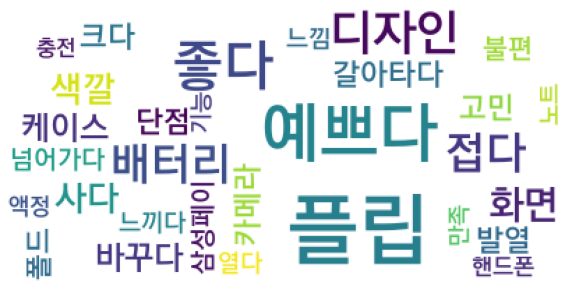

In [ ]:
plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

In [ ]:
cloud.to_file('/content/drive/MyDrive/graduation/flip0508.jpg')

In [ ]:
#z폴드 단어 빈도 및 워드클라우드

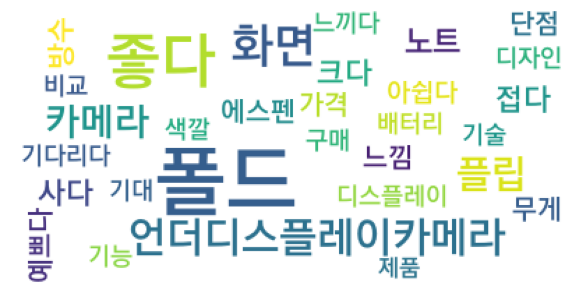

In [ ]:
fold_words = []
for bag in zfold3_comment_words['comment_list'].to_list():
  for w in bag:
    if len(w)>1:
      fold_words.append(w)

counter = Counter(fold_words)
fold_common = counter.most_common(30)

wc = WordCloud(font_path='/content/drive/MyDrive/graduation/SamsungOneKoreanOTF 600.otf',background_color="white", max_font_size=60)
cloud = wc.generate_from_frequencies(dict(fold_common))

cloud.to_file('/content/drive/MyDrive/graduation/fold0508.jpg')

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

In [ ]:
fold_common

[('폴드', 2306),
 ('좋다', 1258),
 ('화면', 723),
 ('언더디스플레이카메라', 607),
 ('플립', 550),
 ('카메라', 527),
 ('노트', 333),
 ('크다', 302),
 ('접다', 291),
 ('사다', 282),
 ('방수', 260),
 ('에스펜', 238),
 ('느낌', 233),
 ('단점', 227),
 ('무게', 223),
 ('가격', 223),
 ('예쁘다', 220),
 ('아쉽다', 205),
 ('기능', 191),
 ('배터리', 183),
 ('디스플레이', 181),
 ('색깔', 174),
 ('기다리다', 167),
 ('구매', 167),
 ('기대', 165),
 ('기술', 164),
 ('느끼다', 162),
 ('비교', 160),
 ('디자인', 160),
 ('제품', 151)]

In [ ]:
commonflipwords = [w for w, i in flip_common]
commonfoldwords = [w for w, i in fold_common]

In [ ]:
#플립, 폴드 공통으로 나타나는 고빈도 어휘
set(commonflipwords).intersection(set(commonfoldwords))

{'기능',
 '노트',
 '느끼다',
 '느낌',
 '단점',
 '디자인',
 '배터리',
 '사다',
 '색깔',
 '예쁘다',
 '접다',
 '좋다',
 '카메라',
 '크다',
 '폴드',
 '플립',
 '화면'}

In [ ]:
#flip에만 나타나는 고빈도 어휘
set(commonflipwords).difference(set(commonfoldwords))

{'갈아타다',
 '고민',
 '넘어가다',
 '만족',
 '바꾸다',
 '발열',
 '불편',
 '삼성페이',
 '액정',
 '열다',
 '충전',
 '케이스',
 '핸드폰'}

In [ ]:
#fold에만 나타나는 고빈도 어휘
set(commonfoldwords).difference(set(commonflipwords))

{'가격',
 '구매',
 '기다리다',
 '기대',
 '기술',
 '디스플레이',
 '무게',
 '방수',
 '비교',
 '아쉽다',
 '언더디스플레이카메라',
 '에스펜',
 '제품'}

In [ ]:
# 토픽모델링 

In [ ]:
import pandas as pd
import re
import wordcloud
import os
import gensim
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
flip_bag = pd.read_csv("/content/drive/MyDrive/graduation/flip_word_bags.csv")
fold_bag = pd.read_csv("/content/drive/MyDrive/graduation/fold_word_bags.csv")

In [ ]:

#플립 학습데이터
flip_vocab = []
for i in range(len(flip_bag['comment_list'])):
  ls = []
  for w in flip_bag['comment_list'][i].replace('[','').replace(']','').split(','):
    ls.append(w.replace("'",'').replace(' ',''))
  flip_vocab.append(ls)

#폴드 학습데이터
fold_vocab = []
for i in range(len(fold_bag['comment_list'])):
  ls = []
  for w in fold_bag['comment_list'][i].replace('[','').replace(']','').split(','):
    ls.append(w.replace("'",'').replace(' ',''))
  fold_vocab.append(ls)

In [ ]:
#LDA

In [ ]:
#플립 댓글의 토픽모델링

In [ ]:
detokenized = []
for i in range(len(flip_vocab)):
  text = ' '.join(flip_vocab[i])
  detokenized.append(text)

In [ ]:
detokenized[:3]

['느끼다 기업 장단점 좋다 건너뛰다 재밌다',
 '가정 순간 센스 넘치다',
 '플립 좋다 개선 정리 시청 배터리 녹다 그리다 지문인식 빠르다 좋다 배터리 발열 개선']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
tfidf = vectorizer.fit_transform(detokenized)

In [ ]:
tfidf.shape

(9898, 1000)

In [ ]:
lda_model = LatentDirichletAllocation(n_components=6,learning_method='online',random_state=777,max_iter=1)
lda_top = lda_model.fit_transform(tfidf)


In [ ]:
terms = vectorizer.get_feature_names()

def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

get_topics(lda_model.components_,terms)

Topic 1: [('배터리', 49.82), ('빼다', 43.8), ('단점', 43.24), ('게임', 37.76), ('갖다', 31.91), ('플립', 30.96), ('아쉽다', 30.45), ('예쁘다', 29.59), ('대박', 27.3), ('발열', 25.01)]
Topic 2: [('화면', 67.97), ('가격', 51.11), ('핸드폰', 47.78), ('플립', 46.84), ('케이스', 46.05), ('액정', 37.69), ('크림', 35.6), ('접다', 33.41), ('예쁘다', 32.29), ('다니다', 32.28)]
Topic 3: [('디자인', 71.65), ('바꾸다', 66.46), ('귀엽다', 55.84), ('감성', 38.53), ('플립', 36.52), ('미치다', 36.41), ('재밌다', 35.63), ('갈다', 35.51), ('닮다', 29.3), ('주다', 27.45)]
Topic 4: [('예쁘다', 407.39), ('사다', 136.81), ('갈아타다', 114.83), ('색깔', 107.64), ('플립', 82.7), ('그린', 58.88), ('실물', 41.88), ('아이패드', 37.0), ('들어오다', 36.49), ('디자인', 36.02)]
Topic 5: [('플립', 188.93), ('폴드', 70.05), ('넘어가다', 60.86), ('카메라', 55.94), ('고민', 44.09), ('크다', 33.58), ('느낌', 32.25), ('기다리다', 31.78), ('좋다', 31.22), ('신경', 30.57)]
Topic 6: [('케이스', 161.85), ('좋다', 132.43), ('접다', 105.48), ('플립', 63.5), ('불편', 49.24), ('열다', 43.68), ('빠지다', 39.68), ('아이폰십삼', 33.69), ('닫다', 32.21), ('화면', 29.95)]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#visualization - flip

In [ ]:
pyLDAvis.sklearn.prepare(lda_model, tfidf, vectorizer)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.201813  0.128882       1        1  19.557506
1     -0.182113  0.071186       2        1  19.159887
4      0.050293 -0.036493       3        1  16.521763
3      0.264667  0.183058       4        1  16.294791
0      0.056728 -0.076372       5        1  15.419023
2      0.012238 -0.270262       6        1  13.047031, topic_info=     Term        Freq       Total Category  logprob  loglift
612   예쁘다  469.000000  469.000000  Default  30.0000  30.0000
884   케이스  195.000000  195.000000  Default  29.0000  29.0000
421    사다  148.000000  148.000000  Default  28.0000  28.0000
23   갈아타다  106.000000  106.000000  Default  27.0000  27.0000
446    색깔   97.000000   97.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
86     구매   23.131440   35.109097   Topic6  -4.2947   1.6193
429   사용자   17.232211   24.031778   Topic6  -4.5891   1.7040
938    플립   41.261129  450.694885   Topic6  -3.7160  -0.3543
175   느끼다   16.845988   61.877725   Topic6  -4.6118   0.7356
795    좋다   15.126715  223.077169   Topic6  -4.7194  -0.6544

[295 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1         2  0.983060    가격
2         3  0.955151    가나
9         2  0.905504   가볍다
12        2  0.965081   가운데
16        3  0.137187    가지
...     ...       ...   ...
991       1  0.946255    후기
996       1  0.961696   휴대성
997       2  0.846321   휴대폰
997       3  0.094036   휴대폰
998       6  0.944532  흔들리다

[357 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 5, 4, 1, 3])

In [ ]:
#폴드 댓글의 토픽모델링

In [ ]:
fold_vocab = []
for i in range(len(fold_bag['comment_list'])):
  ls = []
  for w in fold_bag['comment_list'][i].replace('[','').replace(']','').split(','):
    ls.append(w.replace("'",'').replace(' ',''))
  fold_vocab.append(ls)

In [ ]:
detokenized = []
for i in range(len(fold_vocab)):
  text = ' '.join(fold_vocab[i])
  detokenized.append(text)

vectorizer = TfidfVectorizer(max_features=1000) #max_features=1000
tfidf = vectorizer.fit_transform(detokenized)

In [ ]:
tfidf.shape

(9864, 1000)

In [ ]:
lda_model = LatentDirichletAllocation(n_components=6,learning_method='online',random_state=777,max_iter=1)
lda_top = lda_model.fit_transform(tfidf)

terms = vectorizer.get_feature_names()

def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

get_topics(lda_model.components_,terms)

Topic 1: [('발열', 53.37), ('방수', 50.86), ('핸드폰', 45.16), ('쉽다', 39.16), ('신경', 37.9), ('알리다', 35.26), ('맞다', 30.3), ('게임', 29.2), ('들어오다', 28.51), ('지원', 27.38)]
Topic 2: [('접다', 110.01), ('폴드', 76.56), ('바꾸다', 73.08), ('스마트폰', 65.95), ('찍다', 57.78), ('주름', 48.68), ('기대', 45.5), ('좋다', 41.1), ('플립', 36.88), ('화면', 35.53)]
Topic 3: [('예쁘다', 110.3), ('색깔', 71.72), ('폴드', 70.25), ('아쉽다', 65.35), ('구매', 56.17), ('크다', 53.68), ('두껍다', 46.72), ('필요', 45.26), ('플립', 45.25), ('기능', 44.53)]
Topic 4: [('기다리다', 53.75), ('고민', 41.17), ('가격', 38.14), ('폴드', 32.27), ('미니', 31.51), ('완벽', 31.25), ('넘어가다', 26.51), ('구독', 25.41), ('요즘', 23.81), ('발전', 22.91)]
Topic 5: [('좋다', 187.13), ('사다', 132.02), ('카메라', 70.2), ('언더디스플레이카메라', 62.97), ('케이스', 54.39), ('성능', 51.42), ('폴드', 47.81), ('더블', 42.26), ('폴더', 35.75), ('존버', 31.94)]
Topic 6: [('폴드', 217.5), ('플립', 109.04), ('갖다', 91.38), ('화면', 66.94), ('무겁다', 66.58), ('배터리', 64.87), ('무게', 60.68), ('노트', 59.41), ('단점', 52.36), ('좋다', 49.7)]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# visualization - fold

In [ ]:
pyLDAvis.sklearn.prepare(lda_model, tfidf, vectorizer)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.038044 -0.117977       1        1  19.198631
1     -0.129193 -0.165274       2        1  18.874148
5     -0.126308 -0.106809       3        1  18.340647
4      0.191276 -0.020152       4        1  16.148053
0      0.216531  0.126779       5        1  15.356536
3     -0.190350  0.283433       6        1  12.081986, topic_info=     Term        Freq       Total Category  logprob  loglift
416    사다  135.000000  135.000000  Default  30.0000  30.0000
793    좋다  321.000000  321.000000  Default  29.0000  29.0000
772    접다  106.000000  106.000000  Default  28.0000  28.0000
609   예쁘다  113.000000  113.000000  Default  27.0000  27.0000
27     갖다   80.000000   80.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
60     고민   48.260659   60.256676   Topic6  -3.5317   1.8915
682    이건   15.845822   17.120229   Topic6  -4.6454   2.0361
154  넘어가다   31.072267   43.737678   Topic6  -3.9720   1.7716
1      가격   44.703987   75.729936   Topic6  -3.6082   1.5863
924    폴드   37.826943  433.696730   Topic6  -3.7753  -0.3259

[292 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1         1  0.052819   가격
1         2  0.026410   가격
1         3  0.052819   가격
1         4  0.184867   가격
1         5  0.079229   가격
...     ...       ...  ...
995       3  0.968216   휴대
996       1  0.941519  휴대성
997       2  0.840988  휴대폰
997       4  0.044263  휴대폰
997       5  0.088525  휴대폰

[379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 6, 5, 1, 4])